In [38]:
import pandas as pd
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

In [2]:
read_final = True

if read_final:
    product = pd.read_pickle('./datathon/dataset/final_products')
    outfits = pd.read_pickle('./datathon/dataset/final_outfits')
else:
    o_outfits= pd.read_csv('./datathon/dataset/outfit_data.csv')
    o_product = pd.read_csv('./datathon/dataset/product_data.csv')

    outfits = o_outfits.copy()
    product = o_product.copy()

    #Deleting all the products that are not clothes
    product = product[(product.des_product_category!= 'Beauty') & (product.des_product_category!= 'Home')]
    # Delete all products for men and kids due to desbalance
    product = product[(product.des_line== 'SHE')]
    product = product[(product.des_sex== 'Female')]
    product = product[(product.des_age== 'Adult')]

    product =product.drop(['des_sex','des_line','des_age'], axis = 1)

    # Delete the deleted products from outfits
    outfits = outfits[outfits.cod_modelo_color.isin(product.cod_modelo_color.unique())]

In [3]:
product.head()

,cod_modelo_color,cod_color_code,des_color_specification_esp,des_agrup_color_eng,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_filename,emb
0,41085800-02,02,OFFWHITE,WHITE,P-PLANA,Bottoms,Trousers & leggings,Trousers,Trousers,datathon/images/2019_41085800_02.jpg,"[1.6967614, 1.6967614, 1.6967614, 1.6967614, 1..."
1,53000586-TO,TO,TEJANO OSCURO,BLUE,J-JEANS,Bottoms,Jeans,Jeans,Jeans,datathon/images/2019_53000586_TO.jpg,"[1.6821629, 1.6967614, 1.6967614, 1.6967614, 1..."
2,53030601-81,81,ROSA PASTEL,PINK,P-PLANA,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,datathon/images/2019_53030601_81.jpg,"[1.6967614, 1.6967614, 1.6821629, 1.6821629, 1..."
3,53050730-15,15,MOSTAZA,YELLOW,P-PLANA,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,datathon/images/2019_53050730_15.jpg,"[1.5945723, 1.5799739, 1.5653756, 1.5507771, 1..."
4,53070773-70,70,ROJO,RED,P-PLANA,Tops,Shirts,Shirt,Shirt,datathon/images/2019_53070773_70.jpg,"[1.6383677, 1.6383677, 1.6383677, 1.6383677, 1..."


## AUX FUNCTIONS 

In [4]:
def getProductIdx(idx):
    print("DATOS DEL PRODUCTO")
    print(product.iloc[idx])
    print('OUTFITS APPEARING IN:')
    code = product.iloc[idx].cod_modelo_color
    print(list(outfits[outfits.cod_modelo_color==code]['cod_outfit'].unique()))
    print('IMAGE')
    image_path =product.loc[idx]['des_filename']
    img = cv2.imread(image_path)
    plt.imshow(img)


In [5]:
def getProductByCode(code):
    print("DATOS DEL PRODUCTO")
    print(product.loc[product.cod_modelo_color == code])
    print('OUTFITS APPEARING IN:')
    print(list(outfits[outfits.cod_modelo_color==code]['cod_outfit'].unique()))
    print('IMAGE')
    image_path =product[product.cod_modelo_color == code]['des_filename'].values[0]
    img = cv2.imread(image_path)
    plt.imshow(img)


In [6]:
def printOufit(outfit):
    listaPrednas =  outfits[outfits.cod_outfit==1]['cod_modelo_color'].unique()
    for i in listaPrednas:
        image_path =product[product.cod_modelo_color == i]['des_filename'].values[0]
        img = cv2.imread(image_path)
        plt.imshow(img)
        plt.show()

In [7]:
def getEmbeding(code):
    if code == None:
        return None
    return product[product.cod_modelo_color==code]['emb'].values

# BUSQUEDA LOCAL

In [8]:
def computeHeuristic(embedings):
    sum_distances=0
    for i in range(len(embedings)):
        for j in range(i + 1, len(embedings)):
            distance_ij = np.linalg.norm(embedings[i][0] - embedings[j][0])
            sum_distances += distance_ij
    return sum_distances

In [100]:
def getNewProdSucc(estado, part):    
    data = product.copy()
    match part:
        case "top":
            data  = product.loc[product['des_product_category'] == "Tops"]
        case "bot":
            data = product.loc[product['des_product_category'] == "Bottoms"]
        case "shoes":
            data  = product.loc[product['des_product_family'] == "Footwear"]
    
    newState = None
    while(newState == None):
        randomObs = data.sample(1)
        newProd = randomObs.cod_modelo_color.values[0]
        newState = None
        
        match part:
            case "top":
                 newState = State(newProd, estado.get_bot(), estado.get_shoes())
            case "bot":
                 newState = State(estado.get_top(), newProd, estado.get_shoes())
            case "shoes":
                 newState = State(estado.get_top(), estado.get_bot(), newProd)
            
        newStateH = newState.get_heuristica()
        if newStateH > estado.get_heuristica():
            return newProd 
        newState, newStateH = None, None # reset

In [95]:
def hillClimbing(estado):
    successors = []
    random_seed = None
    
    # top sucesores
    topPart = getNewProdSucc(estado, "top")
    if(topPart != None):
        newState = State(topPart, estado.get_bot(), estado.get_shoes())
        successors.append(newState, newState.get_heuristica())
    
    # bottom sucesores
    botPart = getNewProdSucc(estado, "bot")
    if(bottomPart != None):
        newState = State(estado.get_top(), botPart, estado.get_shoes())
        successors.append(newState, newState.get_heuristica())
        
    # zapatos sucesores
    shoesPart = getNewProdSucc(estado, "shoes")
    if(bottomPart != None):
        newState = State(estado.get_top(), estado.get_bot(), shoesPart)
        successors.append(newState, newState.get_heuristica())
    
    if (len(successors) == 0): return estado
    maxH = successors[0].item(0)
    bestSuccessor = succ.item(0)
    for succ in successors:
        if(maxH > succ.item(1)):
            maxH = succ.item(1)
            bestSuccessor = succ.item(0)
    
    return generateSuccessors(bestSuccessor)

In [110]:
class State:
    def __init__(self, top=None, bot=None, shoes=None, heuristica=np.inf):
        self.top = top
        self.bot = bot
        self.shoes = shoes
        self.heuristica = heuristica
        if (self.top!= None or self.shoes!=None or self.bot!=None): heuristica = computeHeuristic(self.getAllEmbedings())
        print(heuristica)
    def getAllEmbedings(self):
        embedings = [getEmbeding(self.top),getEmbeding(self.bot),getEmbeding(self.shoes)]
        embedings = [emb for emb in embedings if emb!=None]
        return embedings

        
    def getProducts(self):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))  # Create a 1x3 grid of subplots

        # Top
        top_image_path = product[product.cod_modelo_color == self.top]['des_filename'].values[0]
        top_img = cv2.imread(top_image_path)
        axs[0].imshow(top_img)
        axs[0].set_title('Top')

        # Bottom
        bot_image_path = product[product.cod_modelo_color == self.bot]['des_filename'].values[0]
        bot_img = cv2.imread(bot_image_path)
        axs[1].imshow(bot_img)
        axs[1].set_title('Bottom')

        # Shoes
        shoes_image_path = product[product.cod_modelo_color == self.zapatos]['des_filename'].values[0]
        shoes_img = cv2.imread(shoes_image_path)
        axs[2].imshow(shoes_img)
        axs[2].set_title('Shoes')

        plt.show()
    def show_top(self):
        return getProductByCode(self.top)

    def show_bot(self):
        return getProductByCode(self.bot)

    def show_shoes(self):
        return getProductByCode(self.shoes)
    
    def get_top(self):
        return self.top

    def get_bot(self):
        return self.bot

    def get_shoes(self):
        return self.shoes
    
    def get_heuristica(self):
        return self.heuristica

In [111]:
outfit0= State(top='51000622-02',bot='43067759-01')

36.25951385498047


C:\Users\lluis\AppData\Local\Temp\ipykernel_10584\2967428482.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  embedings = [emb for emb in embedings if emb!=None]


In [112]:
out_fin= hillClimbing(outfit0)

C:\Users\lluis\AppData\Local\Temp\ipykernel_10584\2967428482.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  embedings = [emb for emb in embedings if emb!=None]


685.8741455078125
693.6464233398438
370.5150146484375
157.95660400390625
61.28482437133789
61.46727752685547
202.71653747558594
577.8737182617188
742.0712280273438
410.0364990234375
639.7344970703125
233.03353881835938
65.95012664794922
85.25679016113281
398.2918701171875
494.38409423828125
753.0772705078125
188.94200134277344
171.82875061035156
73.56813049316406
358.201904296875
66.45386505126953
796.7263793945312
124.21761322021484
705.5262451171875
101.82254791259766
155.18463134765625
581.6170043945312
452.73834228515625
43.24908447265625
39.31145477294922
555.0457153320312
106.18080139160156
114.67902374267578
736.3607788085938
260.205322265625
120.84635925292969
752.1124877929688
713.9531860351562
673.892578125
137.7650146484375
208.1512908935547
60.8832893371582
88.1050796508789
78.35453033447266
704.6724243164062
240.87924194335938
157.45216369628906
105.16619873046875
360.57623291015625
62.608768463134766
68.01819610595703
108.31785583496094
114.11512756347656
170.947235107421

667.9666137695312
546.3211669921875
136.20623779296875
559.1420288085938
629.6578979492188
409.1733703613281
60.40472412109375
130.88375854492188
74.58882141113281
498.1528015136719
114.39002990722656
186.69268798828125
673.892578125
95.517333984375
80.24332427978516
93.12086486816406
555.1680908203125
562.5396728515625
109.39900970458984
47.84358596801758
117.35586547851562
220.39657592773438
466.3832092285156
184.111083984375
91.60812377929688
111.03244018554688
184.39254760742188
695.401611328125
753.1766967773438
242.68357849121094
550.45654296875
599.5035400390625
120.99500274658203
259.438720703125
82.34037780761719
637.4801025390625
720.7678833007812
419.84661865234375
77.99671173095703
651.2392578125
247.2494354248047
409.4112548828125
186.59597778320312
53.44020080566406
920.4264526367188
202.7232208251953
68.77408599853516
61.323455810546875
373.8984069824219
279.7721252441406
727.604736328125
62.05466842651367
145.63525390625
170.81114196777344
419.84661865234375
285.1092224

719.2443237304688
110.88237762451172
140.33961486816406
149.98690795898438
132.55783081054688
714.8909912109375
172.53219604492188
335.22723388671875
86.94356536865234
70.33269500732422
146.20156860351562
637.4801025390625
835.5278930664062
194.2458038330078
628.1914672851562
545.0723266601562
47.06263732910156
78.53739929199219
773.6770629882812
110.84310150146484
663.1068115234375
39.86038589477539
716.5693969726562
322.6649475097656
105.1631851196289
640.6183471679688
202.8977813720703
95.517333984375
347.8739318847656
47.76393508911133
167.05319213867188
424.5441589355469
595.7245483398438
684.1651000976562
72.95996856689453
181.3245849609375
143.13555908203125
489.7877197265625
85.78190612792969
124.67174530029297
43.70911407470703
719.2443237304688
274.732421875
326.5545959472656
41.97825241088867
72.6312255859375
486.8785095214844
46.95445251464844
671.68359375
697.439208984375
512.5230102539062
635.7311401367188
285.1092224121094
619.4676513671875
436.971435546875
187.522811889

559.0833740234375
85.25679016113281
494.085205078125
107.01994323730469
496.2496032714844
599.5035400390625
106.18080139160156
742.6348876953125
92.33399200439453
793.6173706054688
587.5123901367188
621.7263793945312
182.50933837890625
784.5429077148438
40.808589935302734
204.24620056152344
912.6950073242188
518.9697265625
125.28134155273438
251.1114959716797
406.253662109375
437.4244079589844
68.26884460449219
738.4613037109375
78.52904510498047
810.4507446289062
143.9689178466797
365.43182373046875
591.4592895507812
69.14336395263672
852.403564453125
256.1638488769531
538.6820068359375
38.18359375
51.701202392578125
139.0565948486328
400.3022155761719
704.5195922851562
642.6780395507812
670.9589233398438
732.3228149414062
75.3581314086914
341.28143310546875
52.665191650390625
68.03547668457031
360.93023681640625
782.6553955078125
52.058719635009766
68.03547668457031
567.0408325195312
257.38201904296875
394.1148681640625
400.1960754394531
498.73687744140625
142.4514617919922
840.48950

732.9533081054688
715.1058959960938
754.3568115234375
70.206298828125
445.1055603027344
683.917236328125
247.0359344482422
671.873046875
475.5296936035156
683.7026977539062
555.77294921875
412.5779724121094
695.2222290039062
516.4354248046875
270.0032958984375
470.7648010253906
125.28134155273438
640.4494018554688
199.5145721435547
150.28553771972656
580.5189208984375
424.9371032714844
871.156005859375
63.9212760925293
610.4601440429688
489.3130798339844
289.67742919921875
425.5868225097656
784.5429077148438
385.4590759277344
90.12279510498047
610.0906372070312
251.68798828125
868.3191528320312
80.36940002441406
41.43187713623047
207.49215698242188
49.0623779296875
157.5771942138672
755.98828125
847.110595703125
296.07647705078125
786.238525390625
96.66875457763672
524.6124877929688
385.4590759277344
836.1474609375
170.81114196777344
757.6451416015625
46.40906524658203
627.984375
66.027587890625
78.19436645507812
406.15130615234375
252.011962890625
522.9390869140625
140.02774047851562


399.33294677734375
45.377262115478516
54.19783401489258
607.6406860351562
148.4956817626953
663.7283935546875
334.0085754394531
80.2966537475586
491.99749755859375
55.811668395996094
89.26908874511719
264.4430236816406
521.8460693359375
744.1233520507812
567.5433349609375
391.8807678222656
40.69333267211914
147.7760467529297
230.3628387451172
612.4005737304688
131.15003967285156
300.7527770996094
208.5419464111328
561.4631958007812
293.40814208984375
405.6068115234375
191.2703857421875
479.4298095703125
111.29838562011719
683.2883911132812
42.41436767578125
198.53823852539062
621.3947143554688
208.1512908935547
202.7453155517578
149.98690795898438
70.961181640625
268.439453125
266.51324462890625
556.6180419921875
438.0957336425781
699.5745239257812
612.4005737304688
574.1239013671875
677.691162109375
560.8327026367188
39.86038589477539
142.4514617919922
231.80345153808594
290.6418762207031
165.91726684570312
594.1475219726562
473.2986755371094
824.436279296875
663.3250122070312
72.0733

420.9181823730469
351.88323974609375
497.7701416015625
370.5150146484375
464.5730285644531
851.390380859375
649.7708129882812
310.9867858886719
49.0623779296875
663.36279296875
605.537841796875
743.5562133789062
360.886474609375
298.27655029296875
537.6121215820312
190.35926818847656
276.3306884765625
540.390625
95.41259765625
408.231201171875
516.4354248046875
88.25765991210938
533.9396362304688
46.95445251464844
690.2579956054688
49.16746139526367
577.8737182617188
73.56813049316406
627.2493896484375
63.40314483642578
494.6313171386719
536.7357788085938
354.5281677246094
464.9464416503906
263.6080017089844
517.9296264648438
689.6788330078125
40.056785583496094
111.50408172607422
66.285888671875
55.23624801635742
258.6095275878906
391.57806396484375
452.238525390625
618.1820068359375
111.24427032470703
477.318603515625
392.40234375
391.57806396484375
163.76104736328125
730.5526733398438
702.299560546875
35.46231460571289
626.3019409179688
664.6558227539062
125.7220230102539
573.760131

237.12100219726562
118.63665771484375
105.70741271972656
40.808589935302734
120.99500274658203
127.1753921508789
494.1482849121094
804.0093383789062
62.834388732910156
384.217529296875
537.6121215820312
706.9274291992188
669.703857421875
46.74845504760742
302.880126953125
166.3014373779297
368.5726623535156
342.34283447265625
85.63214874267578
140.49365234375
537.6121215820312
396.89263916015625
258.1636657714844
83.50070190429688
449.84942626953125
272.5278015136719
382.11553955078125
74.74555969238281
42.376739501953125
43.13127517700195
344.80914306640625
263.6887512207031
561.4631958007812
258.6095275878906
41.050933837890625
109.45147705078125
47.76393508911133
602.5374755859375
124.21761322021484
263.5421142578125
75.3058090209961
561.7540283203125
578.5136108398438
685.2523193359375
573.7157592773438
67.3141098022461
65.51448059082031
490.0023193359375
73.89798736572266
36.119075775146484
392.4922180175781
319.50103759765625
95.25827026367188
107.30918884277344
279.7165832519531

256.18170166015625
563.0452880859375
68.01819610595703
251.035400390625
545.4594116210938
119.91431427001953
114.2234115600586
291.5661926269531
44.537559509277344
78.11407470703125
60.72689437866211
64.61723327636719
322.6649475097656
444.41119384765625
56.80014419555664
498.3951721191406
89.26908874511719
280.88018798828125
123.31759643554688
347.2740478515625
413.4337463378906
610.0906372070312
512.5230102539062
538.3353881835938
478.2498474121094
61.7315788269043
292.62908935546875
47.84358596801758
871.156005859375
299.36419677734375
70.21627807617188
191.3601837158203
70.10758209228516
574.4554443359375
123.31759643554688
516.1924438476562
459.8313903808594
776.9719848632812
48.638771057128906
40.53799057006836
79.91061401367188
364.0675964355469
678.4054565429688
559.0833740234375
325.4638671875
245.02000427246094
107.30918884277344
322.0860900878906
364.3913879394531
418.1552734375
94.43685913085938
548.4696044921875
54.395660400390625
252.011962890625
325.30010986328125
421.75

139.15081787109375
755.2735595703125
703.0354614257812
35.05584716796875
561.4631958007812
254.7039337158203
657.9688110351562
74.7906265258789
214.4386749267578
490.3908386230469
42.93813705444336
272.4498596191406
310.81695556640625
673.7014770507812
126.60956573486328
195.50363159179688
62.37384796142578
275.4651184082031
300.7527770996094
563.0452880859375
683.7026977539062
795.1926879882812
198.61663818359375
239.1185760498047
426.1040954589844
224.24037170410156
437.3578796386719
47.80128479003906
731.6795043945312
325.17315673828125
90.30154418945312
391.57806396484375
799.0538330078125
549.279541015625
623.6261596679688
773.6148681640625
627.984375
55.635005950927734
840.489501953125
721.7211303710938
165.8265838623047
291.3608093261719
264.63671875
552.049072265625
50.84762954711914
502.85723876953125
460.8066101074219
142.58290100097656
690.0940551757812
779.34765625
165.8265838623047
75.0572509765625
706.9346923828125
257.3434143066406
771.7057495117188
721.7211303710938
122

640.4494018554688
309.57000732421875
188.97496032714844
208.1512908935547
41.65117263793945
307.8846130371094
376.85382080078125
113.26017761230469
84.05279541015625
59.6713981628418
145.23973083496094
89.59883117675781
29.1143798828125
299.36419677734375
122.21715545654297
570.8419189453125
533.9396362304688
440.7206115722656
144.8995361328125
138.46058654785156
755.2735595703125
336.3789978027344
43.02574920654297
105.43505096435547
73.81145477294922
179.04379272460938
311.3612976074219
486.44317626953125
120.57258605957031
380.5694274902344
159.02487182617188
727.9716186523438
86.66382598876953
179.79408264160156
393.65460205078125
684.0463256835938
115.79763793945312
82.1987075805664
494.646728515625
486.5096740722656
547.0233764648438
705.724609375
72.6312255859375
210.4007568359375
209.39022827148438
611.8992309570312
547.2975463867188
639.1338500976562
643.3787231445312
673.5733032226562
551.1181030273438
481.3677673339844
71.03704833984375
74.50592041015625
106.00967407226562
4

662.987060546875
612.3301391601562
634.7069702148438
600.5240478515625
240.2843780517578
723.7686157226562
83.1728286743164
232.29623413085938
98.1385269165039
586.2947998046875
310.70947265625
52.46692657470703
528.603271484375
75.3058090209961
164.927734375
412.5779724121094
64.14588165283203
334.0085754394531
698.29150390625
52.285682678222656
83.65925598144531
283.4045715332031
69.6965103149414
557.3017578125
577.8737182617188
273.3349914550781
658.8338623046875
683.7026977539062
260.0196533203125
726.4749145507812
155.07757568359375
229.15647888183594
346.4911804199219
42.2235221862793
801.2801513671875
563.2266845703125
177.73851013183594
826.8748168945312
61.323455810546875
307.6255798339844
401.2425537109375
665.6105346679688
257.38201904296875
62.271183013916016
87.08092498779297
369.7110900878906
127.79454803466797
242.3864288330078
101.16400146484375
754.953369140625
303.1689453125
476.28814697265625
659.1201782226562
199.5145721435547
477.0227966308594
814.74951171875
389.3

69.09950256347656
846.0045166015625
53.44020080566406
645.9943237304688
74.56652069091797
225.389404296875
723.9783935546875
36.27915573120117
663.3250122070312
373.7858581542969
43.70911407470703
144.39154052734375
522.0018920898438
743.5562133789062
61.848567962646484
697.1011352539062
61.7315788269043
191.89801025390625
82.5791244506836
653.4512329101562
434.0440673828125
599.304931640625
86.8946304321289
821.16748046875
143.13555908203125
493.9303894042969
57.9400520324707
307.8846130371094
814.74951171875
688.0054931640625
72.95996856689453
122.85709381103516
62.05466842651367
704.8864135742188
78.0718765258789
47.833770751953125
422.32769775390625
561.4631958007812
743.397705078125
56.80353927612305
497.99078369140625
658.70263671875
611.538330078125
73.34215545654297
559.9505615234375
134.397705078125
817.9539184570312
52.46692657470703
777.4866943359375
57.9400520324707
301.5743713378906
515.7997436523438
592.673583984375
186.59597778320312
559.0833740234375
59.57422637939453
3

570.8419189453125
131.6291046142578
446.1463928222656
67.98763275146484
346.4911804199219
263.82342529296875
64.38286590576172
809.4613647460938
224.35406494140625
360.886474609375
202.71653747558594
49.30390548706055
463.3528137207031
125.28134155273438
362.35791015625
98.99336242675781
60.029151916503906
367.0221252441406
54.395660400390625
662.262451171875
40.7729377746582
288.48760986328125
285.3803405761719
793.6900634765625
270.8277893066406
35.94315719604492
607.5457153320312
720.7678833007812
154.4866485595703
744.1233520507812
657.2749633789062
380.5694274902344
99.57418823242188
325.7747497558594
663.1068115234375
115.69876098632812
109.39900970458984
235.9745635986328
85.75345611572266
470.7648010253906
211.8963165283203
296.07647705078125
233.80787658691406
489.9112854003906
272.5278015136719
258.1636657714844
67.02359771728516
167.92457580566406
82.97454071044922
87.05331420898438
607.5457153320312
230.42311096191406
695.9888305664062
635.7311401367188
84.45301818847656
78

181.07705688476562
72.48590087890625
618.8189086914062
68.01819610595703
704.1533203125
865.8986206054688
163.39759826660156
155.18463134765625
392.5559997558594
146.20156860351562
213.16671752929688
520.7381591796875
656.72802734375
51.10633087158203
483.8849792480469
124.17562866210938
707.4390258789062
156.56588745117188
41.050933837890625
676.5435791015625
391.57806396484375
119.91431427001953
575.496826171875
224.8776092529297
83.65925598144531
396.785888671875
660.2030029296875
560.8327026367188
726.4749145507812
78.87395477294922
75.3058090209961
156.05055236816406
427.7371520996094
612.4005737304688
719.5185546875
67.98763275146484
651.247314453125
770.638916015625
84.86832427978516
565.169921875
191.64923095703125
238.7933349609375
92.53466033935547
364.0046081542969
47.15248489379883
83.50070190429688
181.16238403320312
154.92593383789062
307.5942077636719
654.515380859375
94.11576843261719
793.6173706054688
207.2896728515625
283.0557861328125
114.58914947509766
488.297332763

155.07757568359375
412.5779724121094
540.9505615234375
203.8098907470703
126.63037872314453
283.97674560546875
274.732421875
174.3012237548828
187.52877807617188
47.52302551269531
156.4359893798828
736.381103515625
621.0523681640625
156.0077362060547
164.19967651367188
93.5615005493164
304.89312744140625
282.39599609375
558.5113525390625
550.40625
108.03064727783203
99.56817626953125
60.4339485168457
219.26040649414062
42.25201416015625
370.7664489746094
653.8007202148438
82.88900756835938
809.2949829101562
792.5505981445312
592.9134521484375
479.4028625488281
68.77408599853516
555.0457153320312
195.66452026367188
229.0023956298828
597.2644653320312
85.78190612792969
170.33851623535156
342.26385498046875
124.91844177246094
54.3043327331543
694.6569213867188
438.18896484375
385.4595947265625
416.10858154296875
566.226806640625
728.5802612304688
67.02359771728516
256.4234619140625
60.197025299072266
68.77408599853516
166.3014373779297
169.91143798828125
673.5733032226562
61.3266830444335

656.5448608398438
748.4041748046875
74.22942352294922
245.72315979003906
547.66796875
62.660396575927734
640.6183471679688
735.9343872070312
94.88951110839844
101.89679718017578
595.8258666992188
77.7568359375
784.1190185546875
41.65117263793945
40.056785583496094
209.5589599609375
275.3859558105469
58.315277099609375
184.111083984375
526.0802001953125
706.9274291992188
175.06719970703125
614.8521728515625
278.91839599609375
506.23907470703125
555.0457153320312
63.54048156738281
95.19758605957031
752.1124877929688
157.74996948242188
685.2523193359375
692.3297729492188
72.6468505859375
590.8580322265625
743.5562133789062
591.9873046875
292.62908935546875
260.0196533203125
519.9253540039062
78.32022094726562
801.2801513671875
73.34215545654297
832.6029663085938
66.56280517578125
84.45301818847656
50.20696258544922
173.95660400390625
486.204345703125
521.8460693359375
465.7192077636719
540.390625
172.53219604492188
110.84310150146484
764.9371948242188
193.85084533691406
475.04547119140625

300.03997802734375
49.0623779296875
173.95068359375
167.92457580566406
758.6759033203125
79.71943664550781
265.1347351074219
237.4583282470703
425.09808349609375
504.3526916503906
551.6549682617188
366.3052673339844
39.393524169921875
99.17401885986328
281.5958251953125
654.5216674804688
259.438720703125
65.1657485961914
852.5711059570312
495.55975341796875
469.6944580078125
38.18359375
784.5429077148438
840.787353515625
156.56588745117188
376.77081298828125
777.4866943359375
279.7165832519531
699.9900512695312
441.4931335449219
199.98077392578125
146.5038604736328
115.51506042480469
329.6110534667969
624.7221069335938
134.397705078125
578.790283203125
629.7635498046875
109.17767333984375
640.4494018554688
89.13102722167969
600.1673583984375
42.46225357055664
696.2088623046875
741.5465087890625
204.24620056152344
579.8867797851562
688.0054931640625
426.1528015136719
57.9400520324707
157.45216369628906
98.1385269165039
141.38726806640625
265.92120361328125
147.3446807861328
725.37310791

155.05592346191406
463.1936340332031
127.1753921508789
84.67919921875
650.4204711914062
425.5868225097656
477.0227966308594
389.70977783203125
60.40472412109375
840.489501953125
409.09332275390625
98.1385269165039
460.2857666015625
629.5298461914062
322.0860900878906
156.54238891601562
47.297088623046875
629.7635498046875
574.4554443359375
267.6689453125
634.7069702148438
409.09332275390625
675.3251953125
89.59883117675781
485.3994445800781
519.62646484375
843.0757446289062
36.119075775146484
214.11888122558594
209.5589599609375
322.6649475097656
116.99244689941406
444.7768249511719
488.5169372558594
673.7014770507812
303.1689453125
654.515380859375
84.19246673583984
339.8506774902344
472.8202819824219
254.7039337158203
714.8575439453125
112.46276092529297
360.93023681640625
699.5745239257812
663.7283935546875
486.44317626953125
459.8313903808594
190.6332244873047
99.57418823242188
629.5452270507812
595.68310546875
623.2765502929688
494.47015380859375
610.1093139648438
68.1738357543945

610.1093139648438
96.16728210449219
747.0579833984375
515.7997436523438
723.9783935546875
426.2872314453125
368.5242004394531
543.0516357421875
42.98454284667969
114.67902374267578
434.0440673828125
605.6038208007812
281.5958251953125
74.6423568725586
80.05731964111328
235.24835205078125
375.5311584472656
96.27757263183594
640.6183471679688
438.18896484375
291.5661926269531
776.2232055664062
155.05592346191406
163.39759826660156
663.1068115234375
48.00056076049805
108.03064727783203
71.39534759521484
197.35446166992188
36.41934585571289
396.9748229980469
235.8335418701172
664.0365600585938
151.83306884765625
44.22235107421875
458.7109375
47.49609375
36.27915573120117
426.1040954589844
822.2490234375
130.1240997314453
634.5650024414062
366.6749572753906
709.25048828125
190.3982391357422
576.5177001953125
60.197025299072266
77.99671173095703
46.39580535888672
443.19158935546875
52.665191650390625
561.4631958007812
44.94941329956055
622.8722534179688
66.04145812988281
494.646728515625
496

83.50070190429688
510.7094421386719
398.8787841796875
558.5113525390625
447.3117370605469
55.71758270263672
137.56692504882812
341.28143310546875
303.6768798828125
157.5771942138672
41.0308723449707
294.4823913574219
597.385009765625
365.34832763671875
122.01193237304688
755.98828125
673.892578125
144.14927673339844
431.1322021484375
60.4339485168457
522.7522583007812
152.93307495117188
535.998779296875
858.4434204101562
426.1018981933594
67.02359771728516
84.60552215576172
158.7993927001953
56.81097412109375
667.3397216796875
534.9822998046875
45.97206497192383
785.8253784179688
595.7245483398438
260.1337585449219
66.56280517578125
538.6820068359375
590.5745849609375
121.67235565185547
774.6791381835938
440.9053955078125
57.1261100769043
50.041622161865234
39.98292541503906
847.110595703125
311.60382080078125
209.39022827148438
581.6170043945312
49.20759963989258
139.443603515625
641.9290161132812
310.70947265625
320.2762451171875
225.389404296875
248.7982635498047
225.389404296875
66

204.51144409179688
441.0492248535156
393.01202392578125
744.451904296875
524.6124877929688
176.2537384033203
56.02562713623047
724.7427368164062
123.50286865234375
323.8135070800781
654.7639770507812
374.3746337890625
548.8800048828125
474.1676025390625
72.2150650024414
294.4823913574219
396.5010070800781
264.763916015625
170.26556396484375
618.1820068359375
47.342437744140625
43.70911407470703
428.043701171875
37.865333557128906
244.98577880859375
392.8800048828125
874.9298706054688
95.68083190917969
380.5694274902344
98.7021713256836
464.5299072265625
319.1044616699219
38.4405632019043
558.5113525390625
612.3301391601562
186.69268798828125
603.9932861328125
795.7940063476562
134.9657440185547
719.483642578125
746.5653076171875
377.0032043457031
479.4298095703125
268.7966613769531
453.1854248046875
606.925537109375
91.60812377929688
654.7639770507812
60.31869888305664
551.6549682617188
725.193603515625
68.17383575439453
339.8506774902344
639.7344970703125
502.79669189453125
62.0546684

479.4298095703125
64.70396423339844
131.00103759765625
681.328857421875
78.35453033447266
522.0018920898438
37.4755744934082
342.86053466796875
146.65736389160156
83.73397827148438
716.5693969726562
763.431640625
291.5661926269531
609.616455078125
231.80345153808594
287.8623962402344
419.84661865234375
170.94723510742188
236.7284393310547
200.1936492919922
570.9567260742188
690.0940551757812
282.39599609375
164.19967651367188
197.01663208007812
457.44189453125
126.33184814453125
101.15798950195312
101.89679718017578
44.537559509277344
48.32289123535156
440.9053955078125
61.323455810546875
60.99748611450195
494.646728515625
394.1148681640625
125.76838684082031
153.78700256347656
845.8511962890625
131.6291046142578
191.3601837158203
131.6291046142578
522.7522583007812
67.40631866455078
163.5793914794922
407.8408508300781
80.39429473876953
80.05731964111328
362.35791015625
207.11354064941406
385.412841796875
44.369876861572266
552.049072265625
411.3991394042969
68.25286102294922
109.39900


KeyboardInterrupt



In [115]:
out_fin

NameError: name 'out_fin' is not defined

DATOS DEL PRODUCTO
     cod_modelo_color cod_color_code des_color_specification_esp  \
1278      43067759-01             01                      BLANCO   

     des_agrup_color_eng des_fabric des_product_category  \
1278               WHITE    P-PLANA              Bottoms   

     des_product_aggregated_family des_product_family des_product_type  \
1278             Skirts and shorts             Skirts            Skirt   

                              des_filename  \
1278  datathon/images/2019_43067759_01.jpg   

                                                    emb  
1278  [1.7259582, 1.7259582, 1.7259582, 1.7259582, 1...  
OUTFITS APPEARING IN:
[1, 145, 626]
IMAGE


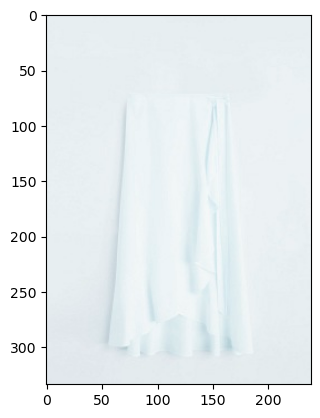

In [31]:
getProductByCode('43067759-01')